In [7]:
import pandas as pd
from shapely.geometry import Point
import fiona
import matplotlib.pyplot as plt
import pdfplumber
import geopandas as gpd
import tabula
import re
import json
import numpy as np
import rioxarray
import rasterio as rio
from geocube.api.core import make_geocube
import os 
import numpy
import rioxarray
import rasterio as rio
import xarray as xr 
import glob

In [4]:
####  admin boundary shape file 
min_lon = 33
min_lat = 3
max_lon = 48
max_lat =15


 
admin_df =gpd.read_file('C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/IBF_DROUGHT_PIPELINE/pipeline/data/input/admin2.geojson')
### import your raser file here , in this case the raster file was stored in a netcdf format 
## this can also be in geotiff format 
lhz_df =gpd.read_file('C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/IBF_DROUGHT_PIPELINE/pipeline/data/input/eth_lhz.geoson.geojson')
### create a new unique identifier with type integer 
lhz_df["cropzone"] = lhz_df.cropzone.astype(int)

### create a new unique identifier with type integer 
admin_df['ind'] = admin_df.apply(lambda row: row.ADM2_PCODE[-4:], axis=1)
admin_df["pcode"] = admin_df.ind.astype(int)


In [44]:
#read observation 
spiforecast='C:/data/FMAM_JanInitial_Forecast_Files/obs_PRCP_Feb-May.tsv'
forecat_period=spiforecast.split('.')[0].split('/')[-1].split('_')[-1]

with open(spiforecast) as file:
    ## the first two lines are not useful 
    file.readline()
    file.readline()
    file.readline()
    cpt_timestamp=file.readline().strip('cpt:T').split('\t')
    # line 3 conaines information on probability, ncol, nrow 
    cpt_items=file.readline().strip('\n').split(',')
    #clim_prob=[items.split("=")[1] for items in cpt_items if  items.split("=")[0]==' cpt:clim_prob'][0]
    ncol=[items.split("=")[1] for items in cpt_items if  items.split("=")[0]==' cpt:ncol'][0]
    nrow=[items.split("=")[1] for items in cpt_items if  items.split("=")[0]==' cpt:nrow'][0]
    clim_time=[items.split("=")[1] for items in cpt_items if  items.split("=")[0]==' cpt:T'][0]
    X=file.readline().split()
    data=[]
    Lines = file.readlines()
    # loop through the rest of the lines, append precipitation values to a list in a format x,y,precipitation, probability
    for line in Lines:
        temp_data=line.split()
        if all([not line.startswith('cpt' ), len(temp_data)!=int(ncol)]):   
            for j in range(int(ncol)):
                data.append([float(temp_data[0]),float(X[j]),float(temp_data[j+1]),clim_time])       
        elif line.startswith('cpt' ):
            cpt_items=line.strip('\n').split(',')
            clim_time=[items.split("=")[1] for items in cpt_items if  items.split("=")[0]==' cpt:T'][0]
    #file_name= self.outputPath + '/' + 'spi_forecast.csv'        
df_observtion = pd.DataFrame(data, index =None, columns =['y','x','precipitation','forecat_time'])
df_observtion.replace({'precipitation': -999}, np.nan,inplace=True)
df_observtion['forecat_time'] = pd.to_datetime(df_observtion['forecat_time'], format='%Y-%m/%d')
df_observtion.set_index(['y', 'x','forecat_time'],inplace=True)
precipitation=df_observtion.to_xarray()
ds_seasonal = precipitation.mean(dim='forecat_time').rio.write_crs("epsg:4326", inplace=True)
ds_seasonal=ds_seasonal.drop('spatial_ref').rename({'precipitation':'prec'}) 

In [45]:
# read forecast 

tsv_files = glob.glob('C:/data/FMAM_JanInitial_Forecast_Files/NextGen_PRCPPRCP_CCAFCST_mu*.tsv')
forecast_df=[]

for spiforecast in tsv_files: 
    forecat_period=spiforecast.split('.')[0].split('/')[-1].split('_')[-2]
    forecat_time=spiforecast.split('.')[0].split('/')[-1].split('_')[-1]
    with open(spiforecast) as file:
        ## the first two lines are not useful 
        file.readline()
        file.readline()
        # line 3 conaines information on probability, ncol, nrow 
        cpt_items=file.readline().strip('\n').split(',')
        #clim_prob=[items.split("=")[1] for items in cpt_items if  items.split("=")[0]==' cpt:clim_prob'][0]
        ncol=[items.split("=")[1] for items in cpt_items if  items.split("=")[0]==' cpt:ncol'][0]
        nrow=[items.split("=")[1] for items in cpt_items if  items.split("=")[0]==' cpt:nrow'][0]
        X=file.readline().split()
        data=[]
        Lines = file.readlines()
        # loop through the rest of the lines, append precipitation values to a list in a format x,y,precipitation, probability
        for line in Lines:
            temp_data=line.split()
            if all([not line.startswith('cpt' ), len(temp_data)!=int(ncol)]):   
                for j in range(int(ncol)):
                    data.append([float(temp_data[0]),float(X[j]),float(temp_data[j+1])])       
            elif line.startswith('cpt' ):
                cpt_items=line.strip('\n').split(',')
                clim_prob=[items.split("=")[1] for items in cpt_items if  items.split("=")[0]==' cpt:clim_prob'][0]


    #file_name= self.outputPath + '/' + 'spi_forecast.csv'        
    df = pd.DataFrame(data, index =None, columns =['y','x',forecat_time])
    df.replace({'precipitation': -999}, np.nan,inplace=True)
    df.set_index(['y', 'x'],inplace=True)
    precipitation=df.to_xarray()
 
    forecast_df.append(precipitation)
    
forecast_df_all = xr.merge(forecast_df).rio.write_crs("epsg:4326", inplace=True)




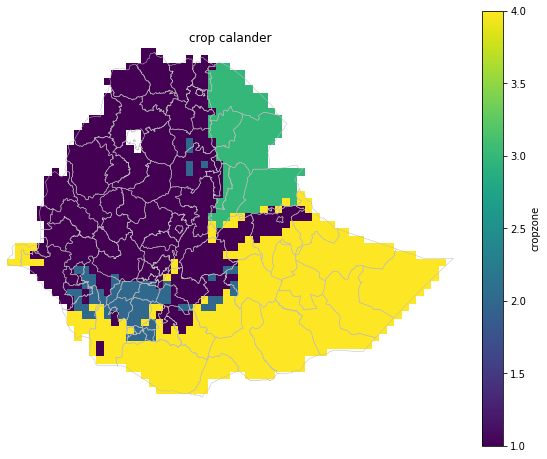

In [16]:
# make your geo cube 
out_grid = make_geocube(
    vector_data=lhz_df,
    measurements=["cropzone"],
    like=ds_seasonal, # ensure the data are on the same grid
)
cropzone=out_grid['cropzone'].to_dataset()

# make your geo cube for admin layer
out_grid = make_geocube(
    vector_data=admin_df,
    measurements=["pcode"],
    like=cropzone, # ensure the data are on the same grid
)


out_grid=out_grid.drop('spatial_ref')
cropzone=cropzone.drop('spatial_ref')
crop_zone=cropzone['cropzone']
#out_grid["seasonal"] = (sesonal_precipitation.dims, sesonal_precipitation.values, sesonal_precipitation.attrs, sesonal_precipitation.encoding)
out_grid["cropzone"] = (crop_zone.dims, crop_zone.values)

f, ax = plt.subplots(figsize=(10, 8))

out_grid.cropzone.plot()#legend=True,legend_kwds={'label': "30th Total Rain for Jun-Sep rainfall average ",'orientation': "horizontal"})
ax.set_title("crop calander")
ax.set_axis_off()
admin_df.boundary.plot(ax=ax,color='#bdbdbd',linewidth=0.5)#,legend_kwds={'label': "30th Total Rain for Jun-Sep rainfall average ",'orientation': "horizontal"})
plt.show() 


In [46]:
ds_masked_ = forecast_df_all#.where(forecast_df_all != -9999) 
df_prediction_ = ds_masked_.to_array(dim='time') 
df_prediction_ = df_prediction_.to_dataset(name='prec')
df_prediction_=df_prediction_.where(df_prediction_['prec'] > 0) 
 

In [47]:
df_mean_prediction_=df_prediction_.mean(dim='time').drop('spatial_ref')
df_mean_prediction_

<xarray.Dataset>
Dimensions:  (x: 60, y: 48)
Coordinates:
  * y        (y) float64 3.125 3.375 3.625 3.875 ... 14.12 14.38 14.62 14.88
  * x        (x) float64 33.12 33.38 33.62 33.88 ... 47.12 47.38 47.62 47.88
Data variables:
    prec     (y, x) float64 95.08 87.74 82.19 71.91 ... 7.509 7.265 5.695 6.327

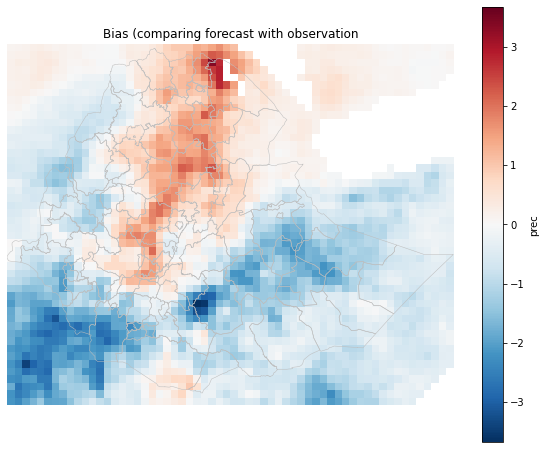

In [55]:

diff=ds_seasonal.prec-df_mean_prediction_.prec
diff=diff.to_dataset()
f, ax = plt.subplots(figsize=(10, 8))
diff.prec.plot()#legend=True,legend_kwds={'label': "30th Total Rain for Jun-Sep rainfall average ",'orientation': "horizontal"})
ax.set_title("Bias (comparing forecast with observation")
ax.set_axis_off()
admin_df.boundary.plot(ax=ax,color='#bdbdbd',linewidth=0.5)#,legend_kwds={'label': "30th Total Rain for Jun-Sep rainfall average ",'orientation': "horizontal"})
plt.show()

In [56]:
ds_masked_ = forecast_df_all#.where(forecast_df_all != -9999) 
df_prediction_ = ds_masked_.to_array(dim='time') 
df_prediction_ = df_prediction_.to_dataset(name='prec')
df_prediction_=df_prediction_.where(df_prediction_['prec'] > 0) 

for i in df_prediction_.time.values:
    df_prediction=df_prediction_.sel(time=i).drop(['time','spatial_ref'])#.to_dataset()
    year_val=i#numpy.datetime_as_string(i, unit='D')
    df_prediction = df_prediction.where(df_prediction['prec'] != -9999)  
    dff=ds_seasonal-df_prediction
    dff=dff.where(dff>2)
    dff1=dff['prec']
    out_grid[f'{year_val}'] = (dff1.dims, dff1.values, dff1.attrs, dff1.encoding)
    #f, ax = plt.subplots(figsize=(10, 8))
    #dff.prec.plot()
    #ax.set_title(f"Below treshold with 40th percentile forecast for {year_val} Keremet")
    #ax.set_axis_off()
    #admin_df.boundary.plot(ax=ax,color='#bdbdbd',linewidth=0.5)
    #plt.show()

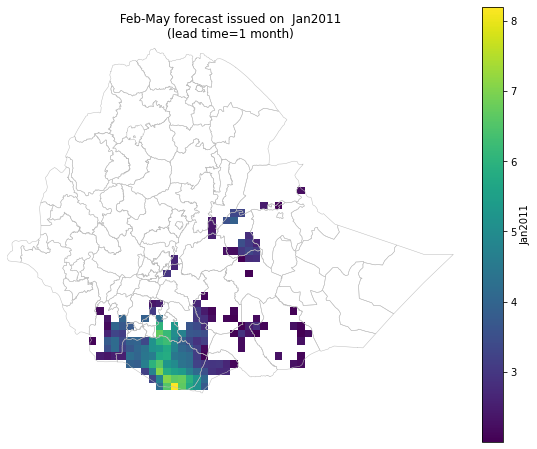

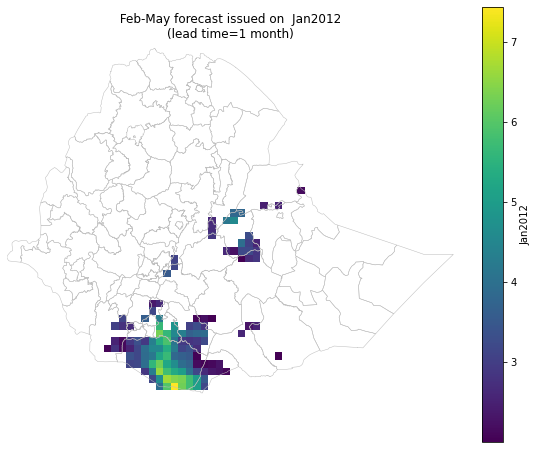

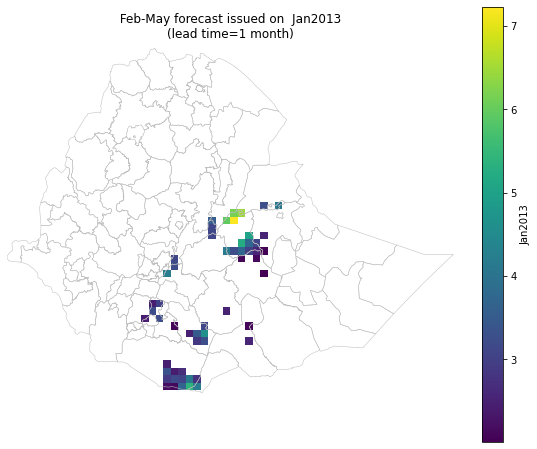

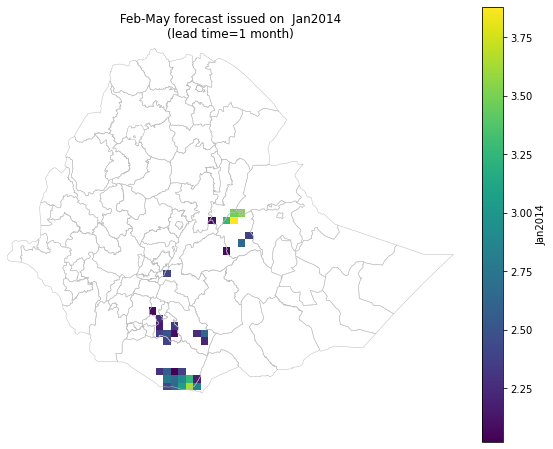

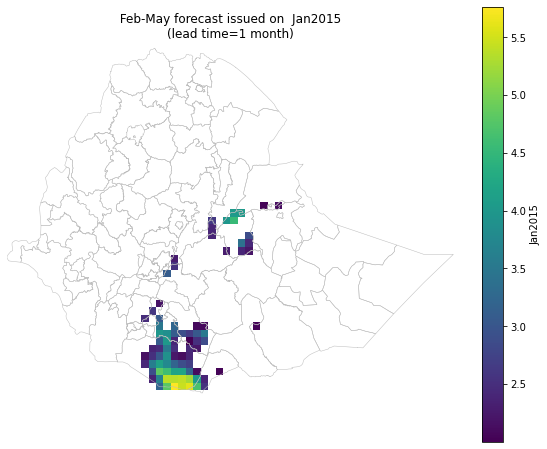

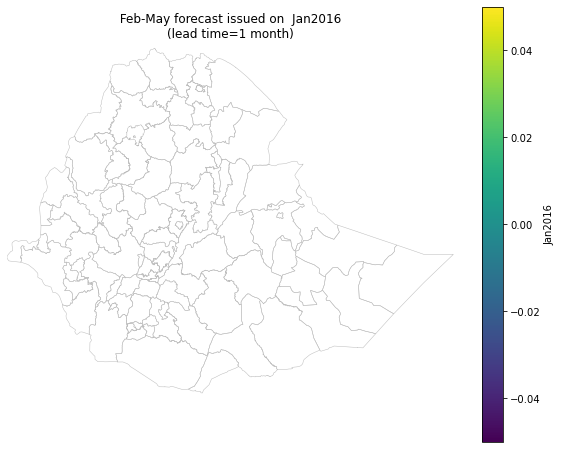

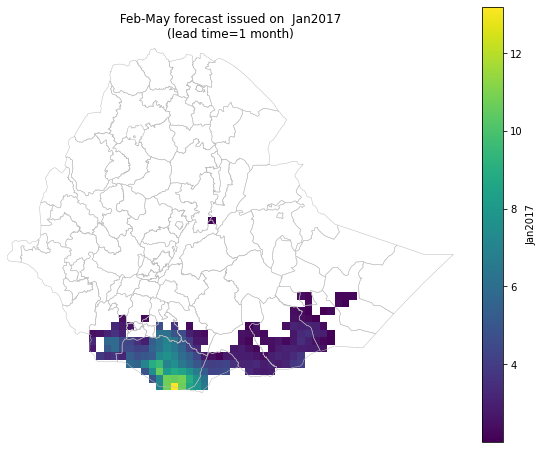

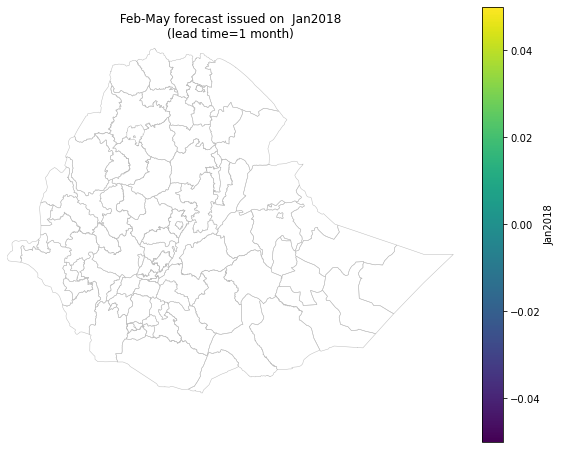

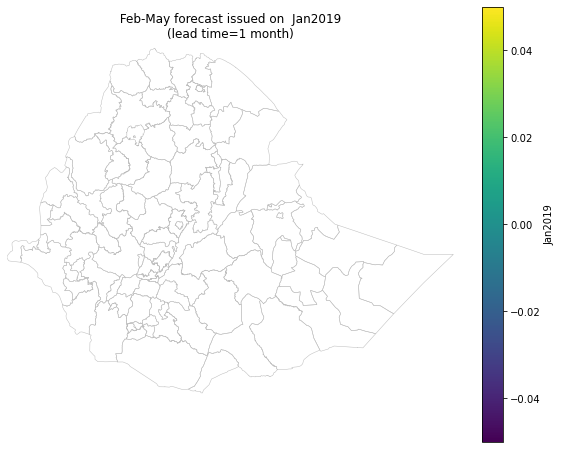

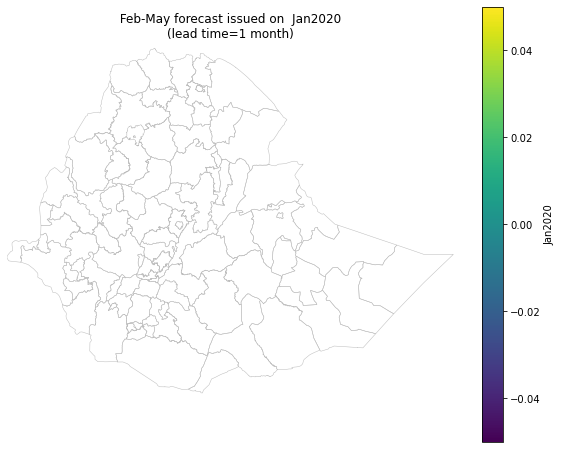

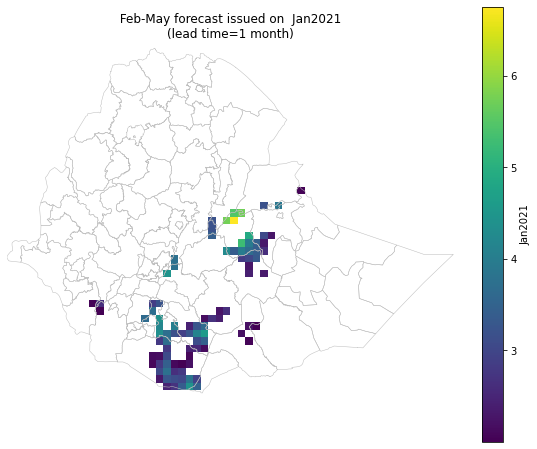

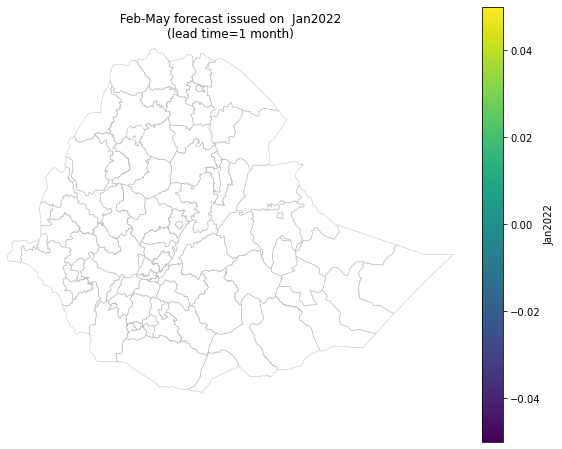

In [59]:
yearly_rain = [i for i in out_grid.drop_vars(['cropzone','pcode']).data_vars] 
meher = out_grid.where(out_grid['cropzone'] == 4) 
for year_rain in yearly_rain:
    f, ax = plt.subplots(figsize=(10, 8))
    meher[year_rain].plot()
    ax.set_title(f" Feb-May forecast issued on  {year_rain} \n(lead time=1 month)",size=12) #Below  average rainfall forecast for
    ax.set_axis_off()
    admin_df.boundary.plot(ax=ax,color='#bdbdbd',linewidth=0.5)
    plt.show()